In [37]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [38]:


train_dir = "data/fer2013/train" 
test_dir = "data/fer2013/test" 
val_dir = "data/fer2013/val" 

transform = transforms.ToTensor()

trainset = datasets.ImageFolder(root=train_dir, transform=transform)

class_to_idx = {"Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Sad": 4, "Surprise": 5, "Neutral": 6}
idx_to_class = {v: k for k, v in class_to_idx.items()}

trainset.class_to_idx = class_to_idx
trainset.classes = list(class_to_idx.keys())

n_classes = len(trainset.classes)

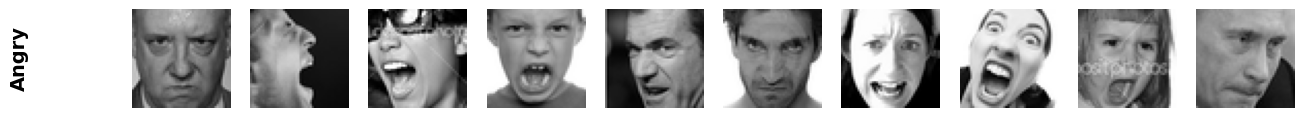

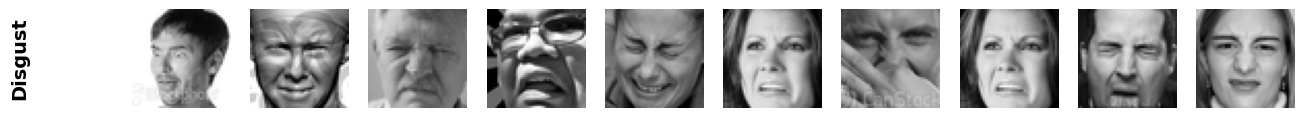

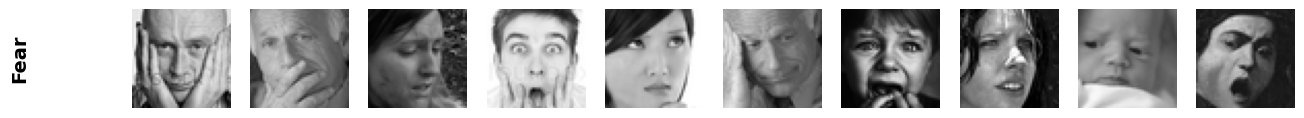

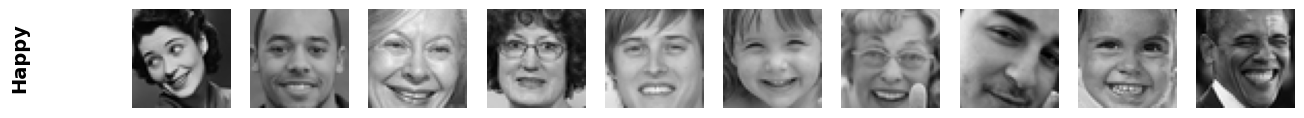

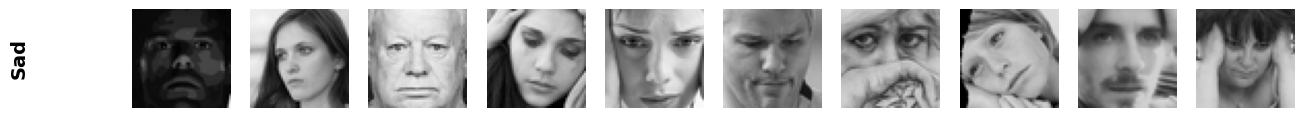

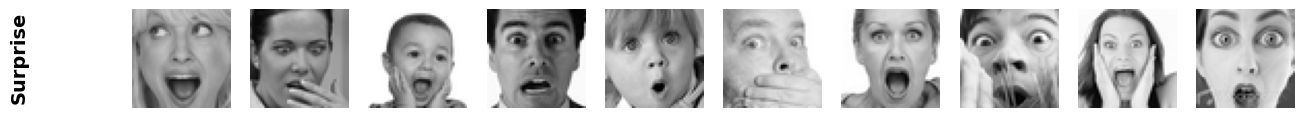

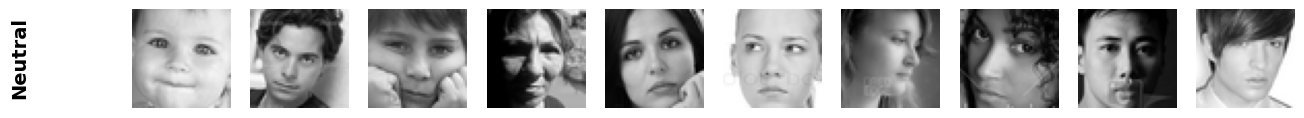

In [ ]:
N = 10

trainloader = DataLoader(trainset, batch_size=None, shuffle=True)

# Find N examples per class
examples = {i: [] for i in range(n_classes)}
for img, label in trainloader:
    if len(examples[label]) < N:
        examples[label].append(img)
    if all(len(examples[i]) == N for i in range(n_classes)):
        break

# Plot examples
for i in range(n_classes):
    fig = plt.figure(figsize=(15, 2))
    for j in range(N):
        plt.subplot(1, N, j+1)
        plt.imshow(examples[i][j].permute(1, 2, 0))
        plt.axis("off")
    fig.text(0.05, 0.5, idx_to_class[i], va="center", ha="center", fontsize=14, fontweight="bold", rotation=90)

    plt.show()
